In [2]:
import sys
sys.executable

'/home/ingn/miniconda3/envs/micron2/bin/python'

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import cv2

import scanpy as sc

import cuml
from micron2.spatial import get_neighbors, categorical_neighbors, sliding_window_niches, k_neighbor_niches
from micron2.clustering import cluster_leiden, run_tsne, plot_embedding, cluster_leiden_cu

from sklearn.cluster import MiniBatchKMeans

import scrna
import tqdm.auto as tqdm

rcParams['figure.facecolor'] = (1,1,1,1)

In [4]:
!ls /storage/codex/datasets_v1

201021_BreastFFPE_Final.hdf5  bladder_TMA1.hdf5
bladder_merged.h5ad	      bone_marrow_merged.h5ad
bladder_merged_v10.h5ad       images
bladder_merged_v4.h5ad	      joined_dataset.h5ad
bladder_merged_v6.h5ad	      merged_v2.h5ad
bladder_merged_v7.h5ad	      merged_v2.hdf5
bladder_merged_v8.h5ad	      merged_v3.h5ad
bladder_merged_v9.h5ad	      merged_v3.hdf5
bladder_TMA1.h5ad	      merged_v3_nosubtract.h5ad


In [5]:
adata = sc.read_h5ad("/storage/codex/datasets_v1/bladder_merged_v10.h5ad")
adata = adata[adata.obs.subtype_rescued!='filtered'].copy()
adata

AnnData object with n_obs × n_vars = 598327 × 1440
    obs: 'CD45_ringpct', 'CD20_ringpct', 'CD3e_ringpct', 'CD45RO_ringpct', 'CD45RA_ringpct', 'CD8_ringpct', 'CD4_ringpct', 'CDH12_ringpct', 'KRT13_ringpct', 'KRT17_ringpct', 'PanCytoK_ringpct', 'ERBB2_ringpct', 'sample_id', 'sample_id_printing', 'snSeq_sample', 'patient', 'biopsy', 'Filtered_DAPI', 'cell_gates', 'celltype_gating', 'subtype_gates', 'subtype_gating', 'subtype_rescued', 'subtype', 'celltype', 'cell_niches', 'niche_labels'
    uns: 'celltype_colors', 'channels', 'niche_profiles_colnames', 'patient_colors', 'sample_id_printing_colors', 'sample_layout', 'snSeq_sample_colors', 'subtype_colors', 'subtype_gating_colors'
    obsm: 'coordinates', 'coordinates_shift', 'niche_profiles'

In [6]:
adata.uns['channels']

array(['DAPI', 'aSMA', 'CD45', 'PDGFRb', 'CD49a', 'CD68', 'CD31', 'CD103',
       'HLA-DR', 'UPK3', 'GATA3', 'CD3e', 'Ki-67', 'CDH18', 'CDH12',
       'KRT13', 'KRT17', 'CK5-6', 'CDH1', 'PD-1', 'CD11c', 'KRT20',
       'CD69', 'PD-L2', 'CD20', 'PD-L1', 'FOXP3', 'ERBB2', 'GZMB', 'CD44',
       'CD45RO', 'LAG3', 'CD45RA', 'CD8', 'CD4', 'PanCytoK'], dtype=object)

# all samples in a dataset

In [9]:
all_clusters = adata.obs['celltype'].copy()
cluster_levels, all_clusters = np.unique(all_clusters, return_inverse=True)

all_neighbor_profiles = []
obs_reshuffle = []
with tqdm.tqdm(np.unique(adata.obs.sample_id)) as pbar:
    for s in pbar:
        pbar.set_description(s)
        ad = adata[adata.obs.sample_id == s]
        obs_reshuffle.append( np.array(adata.obs_names[adata.obs.sample_id == s]) )

        coords = ad.obsm['coordinates'].copy()

        # Flip the height coordinate
        coords[:,1] = -coords[:,1]
        clusters = all_clusters[adata.obs.sample_id == s]
        neighbor_profiles = k_neighbor_niches(coords, clusters, k = 10, 
                                              u_clusters=np.arange(len(cluster_levels)), 
                                              aggregate='sum', max_dist=200)

        all_neighbor_profiles.append(neighbor_profiles.copy())
    
all_neighbor_profiles = np.concatenate(all_neighbor_profiles, axis=0)
OBS_reshuffle = np.concatenate(obs_reshuffle)

  0%|          | 0/75 [00:00<?, ?it/s]

In [10]:
from sklearn.metrics import roc_auc_score
overall_aucs = {}
all_models = {}
all_niche_vectors = {}

np.random.seed(999)
for k in tqdm.tqdm([5, 10, 15, 20, 25, 30, 35, 40, 45, 50]):
    MBKM = MiniBatchKMeans(n_clusters=k, batch_size=1000, n_init=10, random_state=999)
    niches = MBKM.fit_predict(all_neighbor_profiles)

    niche_levels , niches = np.unique(niches, return_inverse=True)
    # print(len(niche_levels))
    # for n in niche_levels:
    #     print(f'{n}: {np.sum(niches==n)}')

    """
    Find optimal niche number by testing 1-vs-rest prediction AUC
    """
    aucs = []
    coefs = []
    training = np.random.choice([0,1], niches.shape[0])==1
    for test_niche in tqdm.tqdm(niche_levels):
        Xtrain_1  = all_neighbor_profiles[(niches == test_niche)&training]
        Xtrain_2 = all_neighbor_profiles[(niches != test_niche)&training]
        X = np.concatenate([Xtrain_1,Xtrain_2], axis=0)
        X = (X.T / X.sum(axis=1)).T
        Y = np.array([1]*Xtrain_1.shape[0] + [0]*Xtrain_2.shape[0])
        cls = cuml.LogisticRegression()
        cls.fit(X, Y)
#         cls = cuml.neighbors.KNeighborsClassifier(n_neighbors=100)
#         cls.fit(X, Y)

        Xtest_1  = all_neighbor_profiles[(niches == test_niche)&~training]
        Xtest_2 = all_neighbor_profiles[(niches != test_niche)&~training]
        Xtest = np.concatenate([Xtest_1,Xtest_2], axis=0)
        Xtest = (Xtest.T / Xtest.sum(axis=1)).T
        Ytest = np.array([1]*Xtest_1.shape[0] + [0]*Xtest_2.shape[0])
        Ypred = cls.predict_proba(Xtest)
        aucs.append(roc_auc_score(Ytest==1, Ypred[:,1]))
        coefs.append(cls.coef_.copy())
    
    overall_aucs[k] = aucs
    all_models[k] = coefs
    all_niche_vectors[k] = niches.copy()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

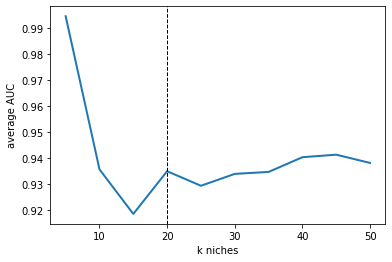

In [14]:
rcParams['svg.fonttype'] = 'none'
ks = []
avg_aucs = []
for k,v in overall_aucs.items():
    ks.append(k)
    avg_aucs.append(np.mean(v))
    
plt.plot(ks, avg_aucs, lw=2)
plt.ylabel('average AUC')
plt.xlabel('k niches')
plt.gca().axvline(20, lw=1, color='k', ls='--')
plt.savefig('figures/niche_k_selection.svg', bbox_inches='tight', transparent=True)

In [33]:
best_k = 20
models = all_models[best_k]
niche_names = {}

for i,coef in enumerate(models):
    c = coef.flatten()
    srt = np.argsort(c)[::-1][:3]
    #print(c[srt])
    #j = [cluster_levels[k] for k in srt if c[k]>0]
    #j = [(cluster_levels[k], c[k]) for k in srt]
    j = []
    for k in srt:
        n = cluster_levels[k]
        s = c[k]
        if s < 1:
            break
        j.append(n)
    name = ';'.join(sorted(j))
    print(i, name)
    niche_names[f'{i:02d}'] = name
    
niches = all_niche_vectors[best_k]

0 Epithelial;Epithelial_CDH
1 Endothelial;Epithelial_CDH;Mac
2 CD4T;CD8T;Stromal
3 Epithelial
4 Epithelial_CDH
5 Stromal
6 Bcell
7 CD8T;Mac
8 Epithelial;Stromal
9 CD8T;Endothelial;Stromal
10 Endothelial
11 CD8T
12 Endothelial;Mac;Stromal
13 Epithelial;Epithelial_CDH
14 CD4T;CD8T;Mac
15 Bcell;CD4T
16 Mac
17 CD4T
18 Endothelial;Epithelial;Mac
19 Mac;Stromal


In [34]:
adata.obs['cell_niches'] = pd.DataFrame(niches , index=OBS_reshuffle, dtype='category')
adata.obs['cell_niches'] = pd.Categorical([f'{x:02d}' for x in adata.obs['cell_niches']])

niche_groups_v = [niche_names[n] for n in adata.obs['cell_niches']]
adata.obs['niche_labels'] = pd.Categorical(niche_groups_v)

In [35]:
profiles_df = pd.DataFrame(all_neighbor_profiles, index=OBS_reshuffle, columns=cluster_levels)
profiles_df = profiles_df.loc[adata.obs_names, :]
adata.obsm['niche_profiles'] = profiles_df.values
adata.uns['niche_profiles_colnames'] = cluster_levels
profiles_df

Bcell  CD4T  CD8T  Endothelial  \
cell_283_2404-210226_Bladder_TMA1_reg10_v5    0.0   0.0   0.0          0.0   
cell_285_2427-210226_Bladder_TMA1_reg10_v5    0.0   0.0   0.0          0.0   
cell_281_2223-210226_Bladder_TMA1_reg10_v5    0.0   0.0   1.0          0.0   
cell_307_1976-210226_Bladder_TMA1_reg10_v5    0.0   0.0   0.0          0.0   
cell_304_2235-210226_Bladder_TMA1_reg10_v5    0.0   0.0   1.0          0.0   
...                                           ...   ...   ...          ...   
cell_3856_2029-210311_Bladder_TMA3_reg9_v5    0.0   0.0   0.0          0.0   
cell_3852_2380-210311_Bladder_TMA3_reg9_v5    0.0   2.0   1.0          1.0   
cell_3859_1812-210311_Bladder_TMA3_reg9_v5    0.0   0.0   1.0          0.0   
cell_3857_2003-210311_Bladder_TMA3_reg9_v5    0.0   0.0   0.0          0.0   
cell_3859_1882-210311_Bladder_TMA3_reg9_v5    0.0   0.0   1.0          0.0   

                                            Epithelial  Epithelial_CDH  Mac  \
cell_283_2404-210226_Bladder_TMA1_reg10_v5         0.0             0.0  0.0   
cell_285_2427-210226_Bladder_TMA1_reg10_v5         0.0             0.0  0.0   
cell_281_2223-210226_Bladder_TMA1_reg10_v5         1.0             0.0  0.0   
cell_307_1976-210226_Bladder_TMA1_reg10_v5         7.0             0.0  1.0   
cell_304_2235-210226_Bladder_TMA1_reg10_v5         2.0             0.0  0.0   
...                                                ...             ...  ...   
cell_3856_2029-210311_Bladder_TMA3_reg9_v5         6.0             1.0  1.0   
cell_3852_2380-210311_Bladder_TMA3_reg9_v5         4.0             1.0  0.0   
cell_3859_1812-210311_Bladder_TMA3_reg9_v5         7.0             2.0  1.0   
cell_3857_2003-210311_Bladder_TMA3_reg9_v5         6.0             0.0  1.0   
cell_3859_1882-210311_Bladder_TMA3_reg9_v5         6.0             2.0  1.0   

                                            Stromal  
cell_283_2404-210226_Bladder_TMA1_reg10_v5     11.0  
cell_285_2427-210226_Bladder_TMA1_reg10_v5     11.0  
cell_281_2223-210226_Bladder_TMA1_reg10_v5      9.0  
cell_307_1976-210226_Bladder_TMA1_reg10_v5      3.0  
cell_304_2235-210226_Bladder_TMA1_reg10_v5      8.0  
...                                             ...  
cell_3856_2029-210311_Bladder_TMA3_reg9_v5      3.0  
cell_3852_2380-210311_Bladder_TMA3_reg9_v5      2.0  
cell_3859_1812-210311_Bladder_TMA3_reg9_v5      0.0  
cell_3857_2003-210311_Bladder_TMA3_reg9_v5      4.0  
cell_3859_1882-210311_Bladder_TMA3_reg9_v5      1.0  

[598327 rows x 8 columns]

In [36]:
adata.obs.niche_labels.value_counts()

Epithelial                        180991
Endothelial;Epithelial;Mac         65183
Epithelial;Epithelial_CDH          65172
CD4T;CD8T;Mac                      39005
Epithelial;Stromal                 23262
Stromal                            23227
Epithelial_CDH                     19295
Endothelial;Mac;Stromal            18942
CD8T;Endothelial;Stromal           18593
CD8T                               17721
Endothelial;Epithelial_CDH;Mac     17247
Mac                                17038
CD8T;Mac                           16299
Bcell;CD4T                         14870
CD4T                               14325
Mac;Stromal                        12611
CD4T;CD8T;Stromal                  12452
Endothelial                        11907
Bcell                              10187
Name: niche_labels, dtype: int64

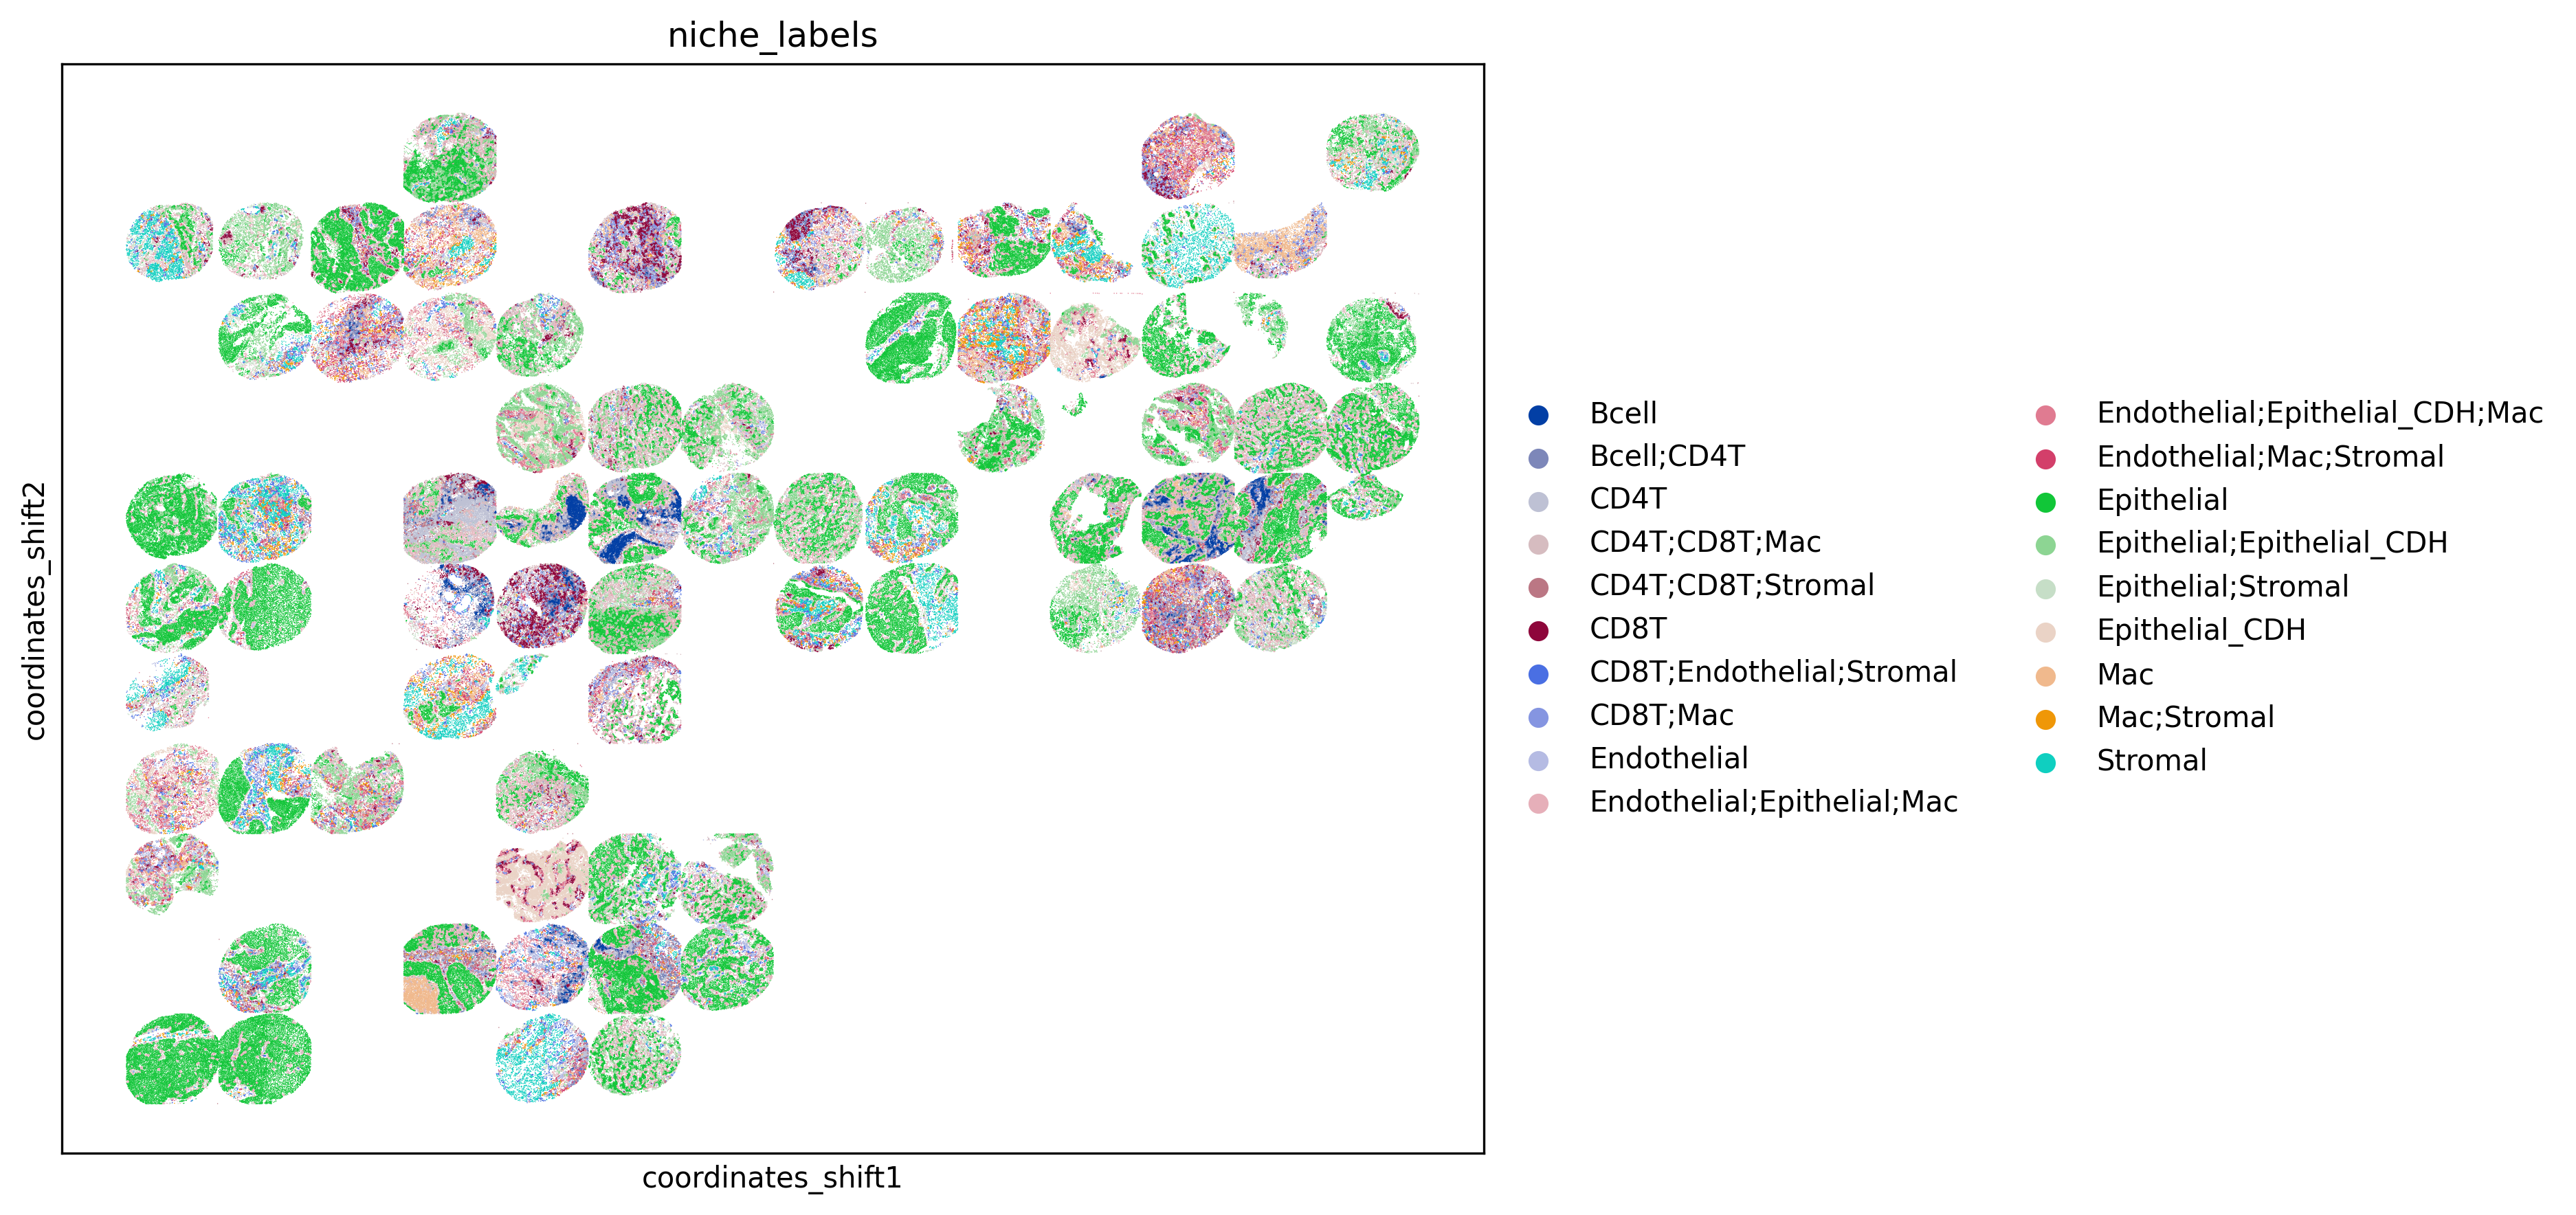

In [37]:
r = np.max(np.abs(adata.obsm['coordinates_shift']), axis=0)
r = r[0]/r[1]
plt.figure(figsize=(r*7,7), dpi=300) 
sc.pl.embedding(adata, basis='coordinates_shift', color='niche_labels', 
                ax=plt.gca(), s=0.5)

/home/ingn/devel/scrna/scrna/plotting_utils.py:587: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(u_groups, fontsize=6, rotation=90)


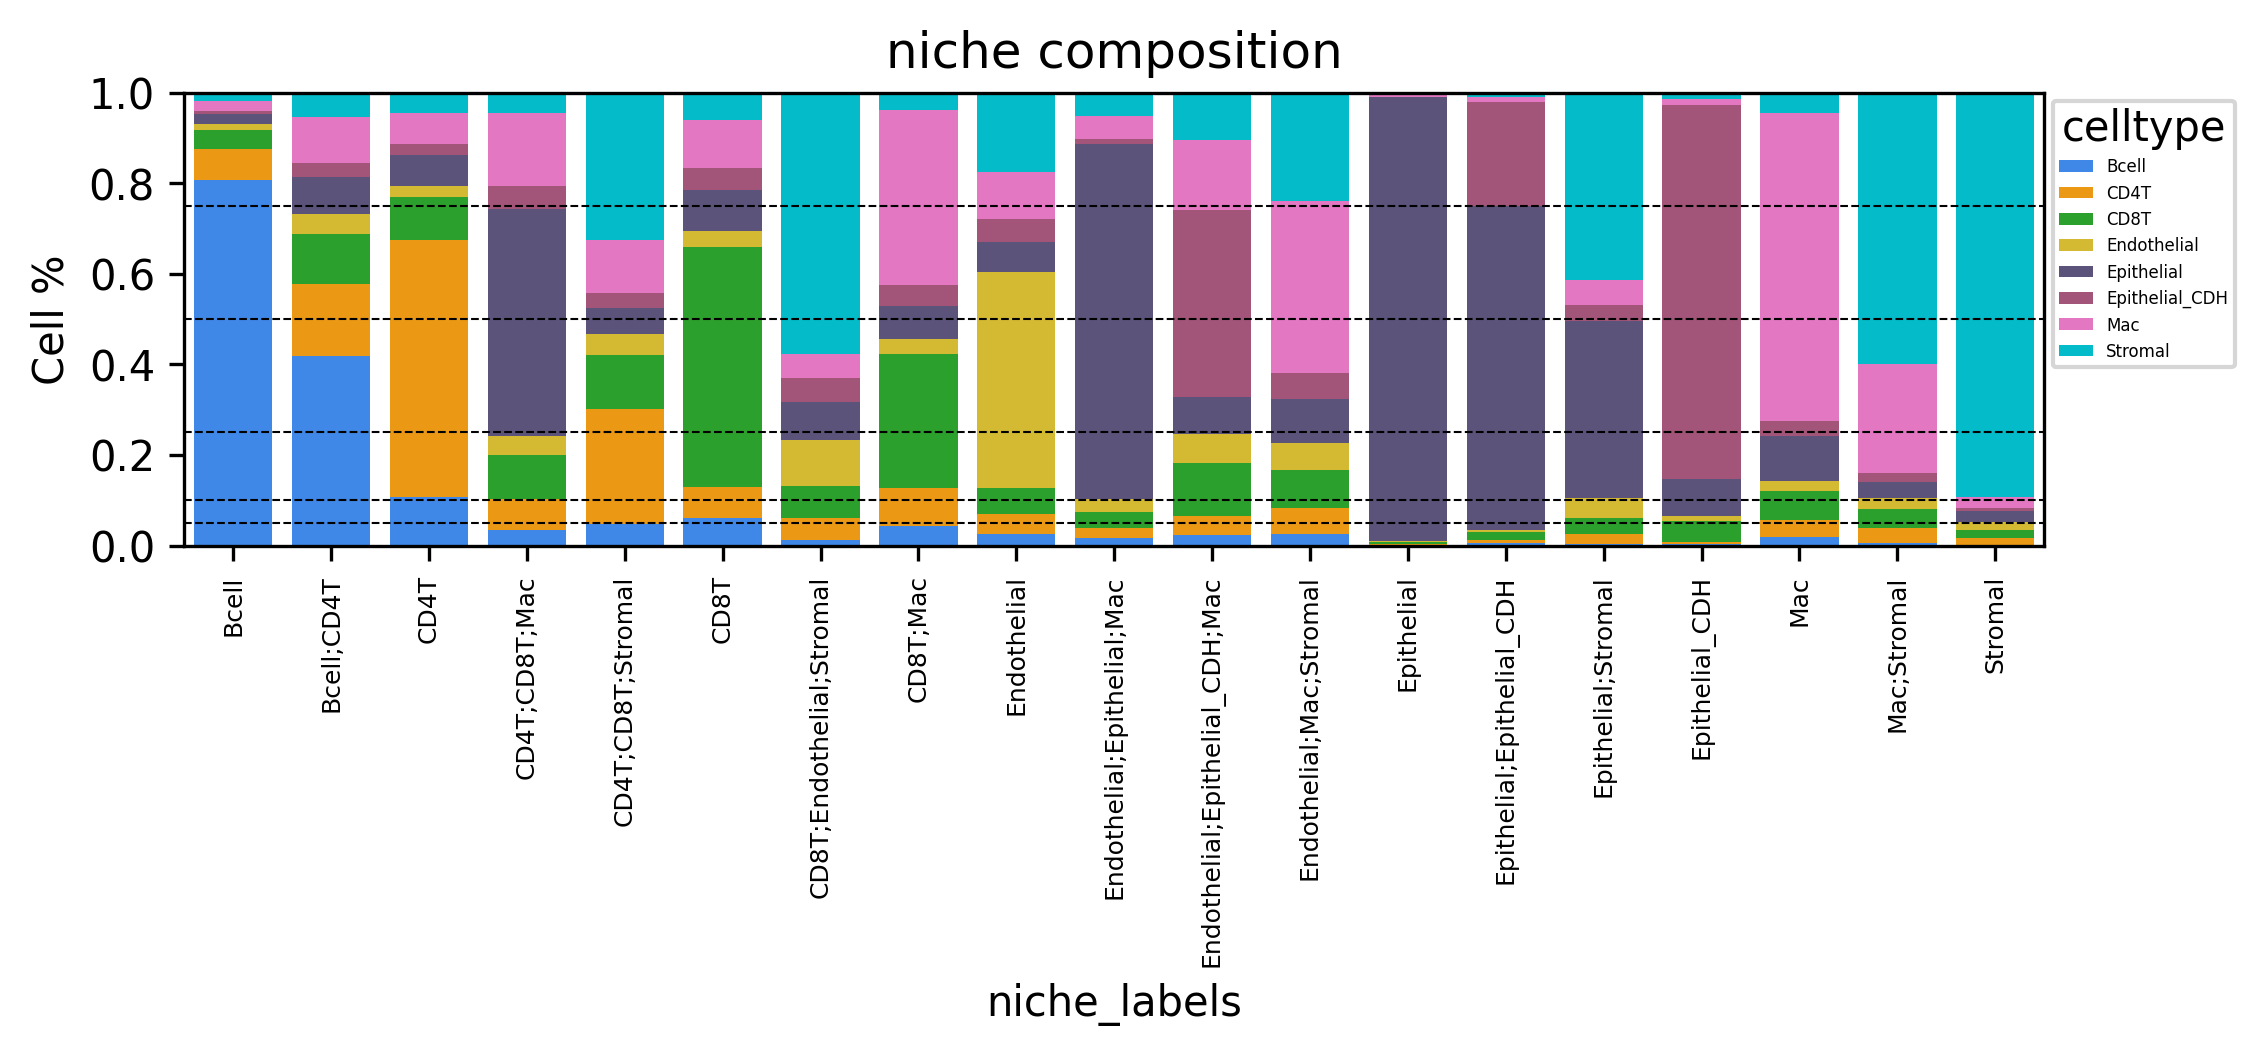

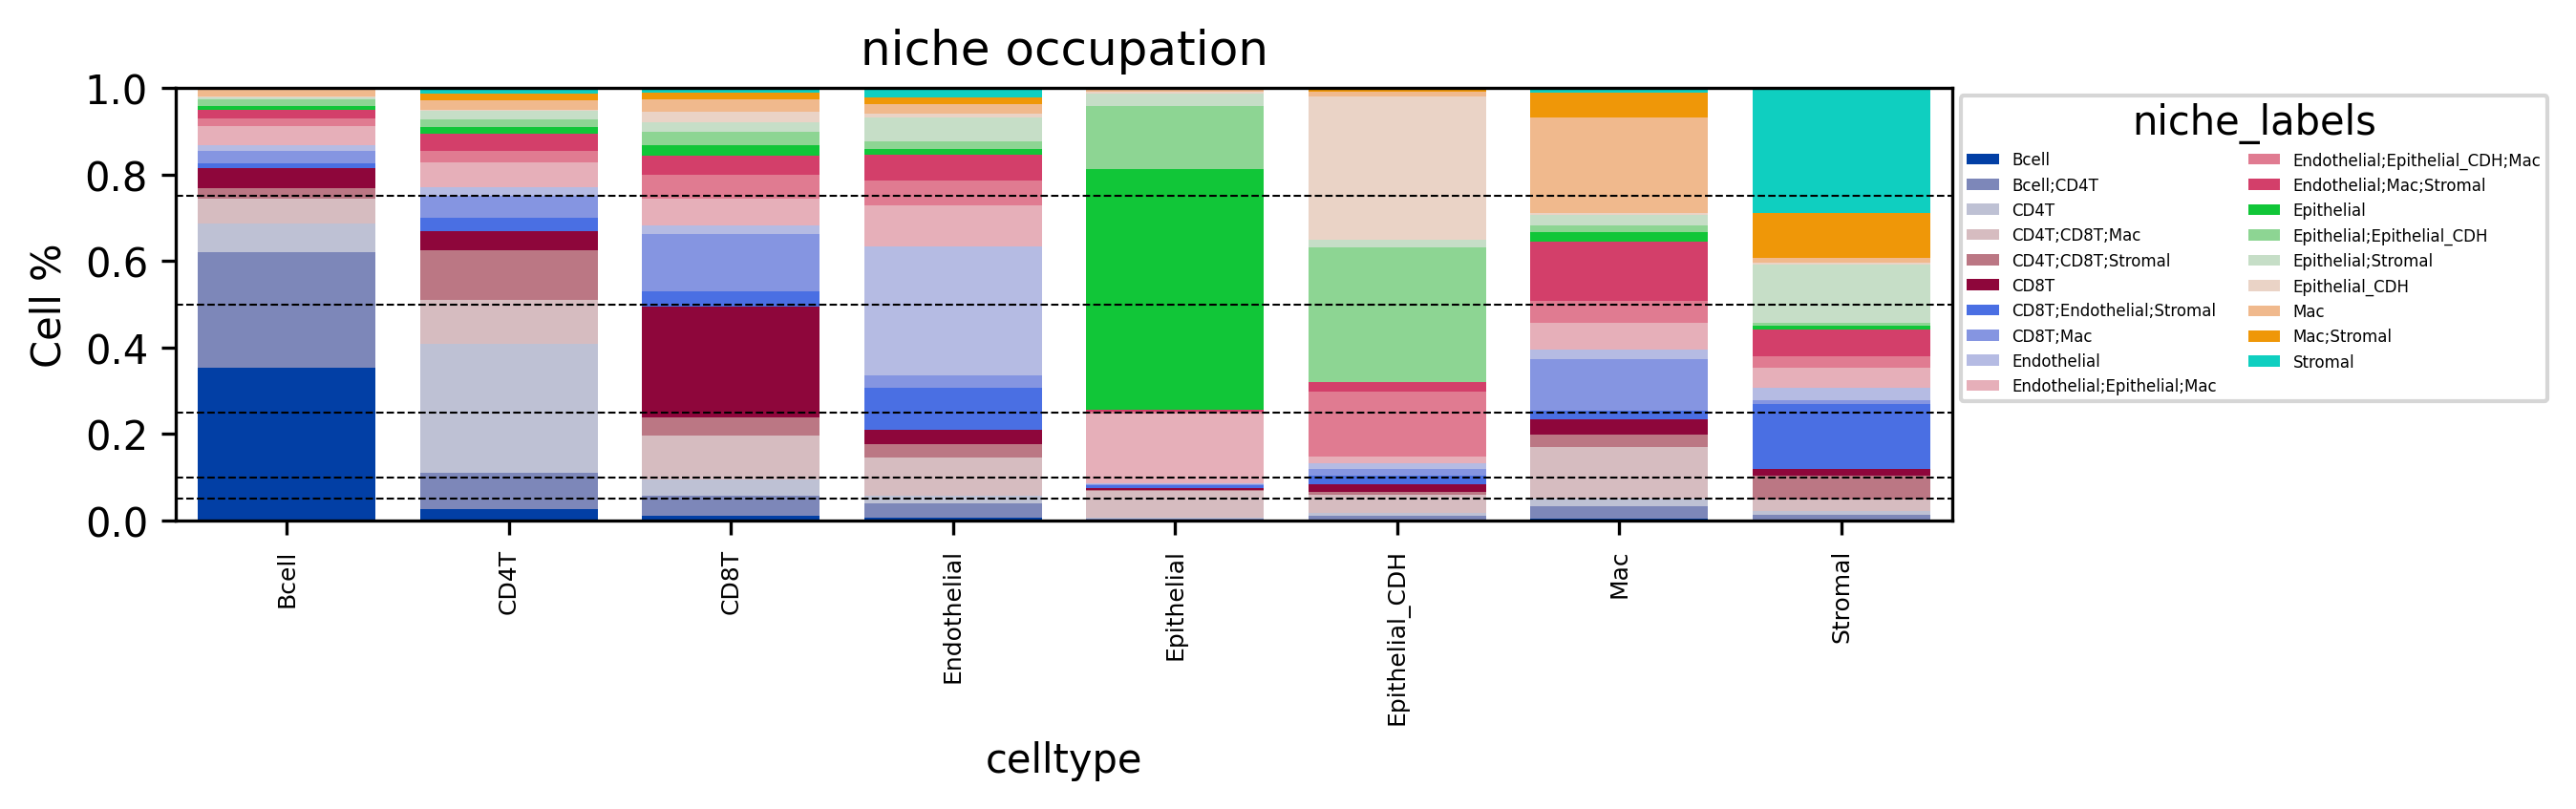

In [39]:
u_celltypes = np.unique(adata.obs.celltype)
scrna.plot_group_percents(adata, 'celltype', 'niche_labels',
                          title = 'niche composition',
                          colors={k:c for k,c in zip(u_celltypes,adata.uns['celltype_colors'])},
                          annotate_total=False)

u_niches = np.unique(adata.obs.niche_labels)
scrna.plot_group_percents(adata, 'niche_labels', 'celltype', title='niche occupation',
                          colors={k:c for k,c in zip(u_niches,adata.uns['niche_labels_colors'])},
                          annotate_total=False)

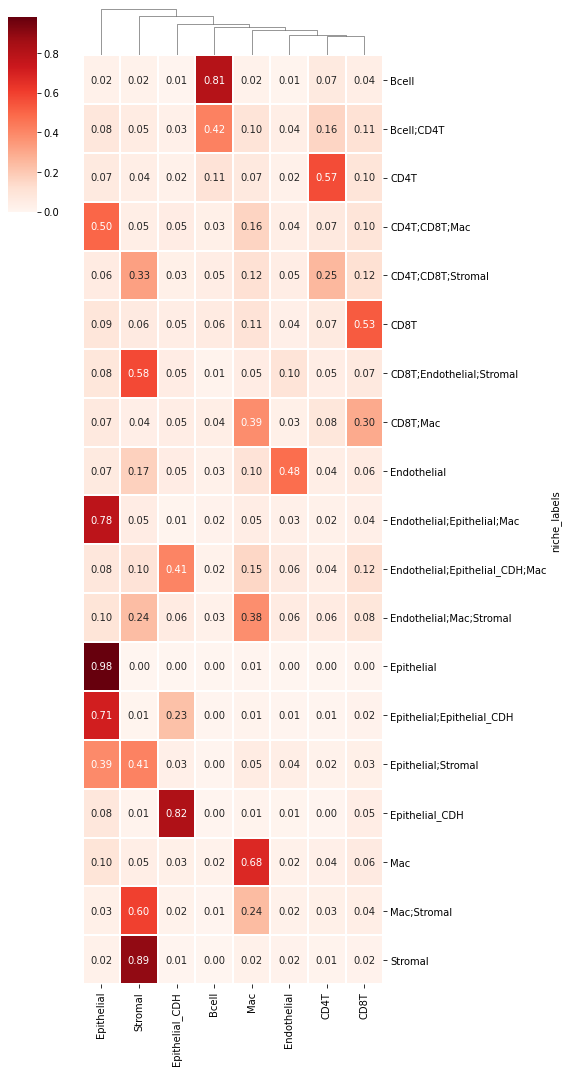

In [45]:
from matplotlib import rcParams
rcParams['figure.facecolor'] = (1,1,1,1)
u_celltypes = np.unique(adata.obs.celltype)
def count_fn(x):
    l, c = np.unique(x['celltype'], return_counts=True)
    z = np.zeros(len(u_celltypes), dtype=np.int)
    for i,r in zip(l,c):
        z[u_celltypes==i] = r
    z = z/np.sum(c)
    return pd.Series(z, index=u_celltypes)

cols = ['niche_labels', 'celltype']
df = adata.obs.loc[:, cols].copy()
# df
df = df.groupby('niche_labels').apply(count_fn)

sns.clustermap(df, square=True, yticklabels=True, lw=1, cmap='Reds', 
               row_cluster=False,
               dendrogram_ratio=(0.2, 0.05),
               annot=True,
               fmt='2.2f',
               figsize=(8,15)
              )


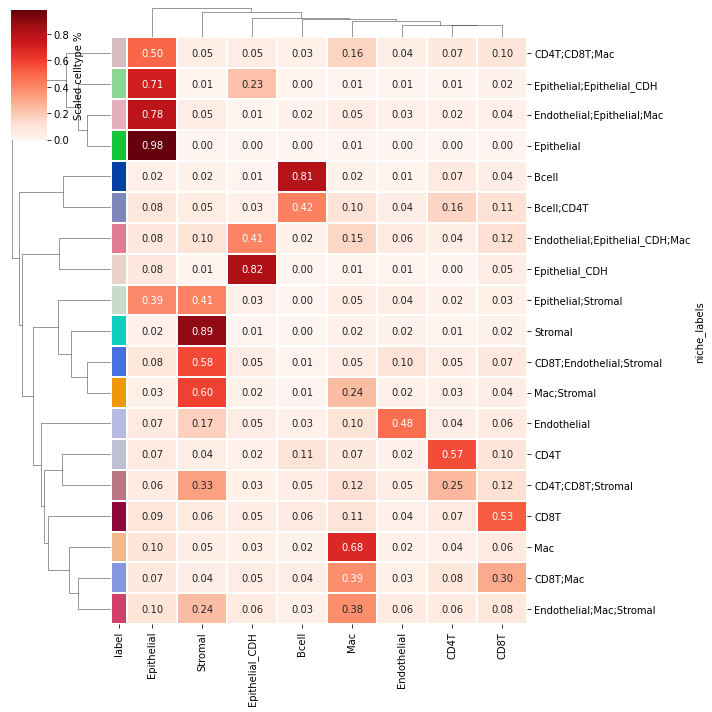

In [49]:
u_niche_labels = np.unique(adata.obs.niche_labels)
colors = adata.uns['niche_labels_colors']
row_colors = pd.DataFrame(index=np.arange(20), columns=['label'])
for j,v in sorted(niche_names.items()):
    c = colors[np.argwhere(u_niche_labels==v).flatten()[0]]
    row_colors.loc[v,'label'] = c
    
sns.clustermap(df, square=True, yticklabels=True, lw=1, cmap='Reds', 
               dendrogram_ratio=(0.2, 0.05),
               annot=True,
               fmt='2.2f',
               row_colors=row_colors,
               figsize=(10,10),
               #standard_scale=1,
               cbar_kws=dict(label='Scaled celltype %')
               )

In [116]:
from scipy.stats import pearsonr
correlations = pd.DataFrame(index=u_niches, columns=u_subtypes, dtype=np.float32)
for niche, subtype in itertools.product(u_niches, u_subtypes):
    n = spot_niches[niche]
    s = spot_subtypes[subtype]
    cor = pearsonr(n,s)
    correlations.loc[niche, subtype] = cor[0]
    

Bcell      CD4T  CD4T_Treg      CD8T  \
Bcell                           0.938524  0.318142   0.544136 -0.095899   
Bcell;CD4T                      0.925205  0.539980   0.410670  0.057823   
CD4T                            0.434027  0.840755   0.732568 -0.044225   
CD4T;CD8T;Mac                   0.256571  0.193733   0.399381  0.357696   
CD4T;CD8T;Stromal               0.212206  0.699646   0.144611  0.157764   
CD8T                            0.298111  0.220615  -0.054690  0.516320   
CD8T;Endothelial;Stromal       -0.038215  0.150379  -0.225092 -0.019464   
CD8T;Mac                        0.096346  0.162839  -0.116351  0.687302   
Endothelial                     0.330489  0.289723  -0.139471  0.098800   
Endothelial;Epithelial;Mac     -0.114405 -0.176568   0.157820 -0.141254   
Endothelial;Epithelial_CDH;Mac  0.088415  0.090675  -0.132650  0.125782   
Endothelial;Mac;Stromal         0.015025  0.135733  -0.143236  0.266930   
Epithelial                     -0.278447 -0.355789  -0.082475 -0.374510   
Epithelial;Epithelial_CDH      -0.254177 -0.199395  -0.111439 -0.028559   
Epithelial;Stromal             -0.348125 -0.247158  -0.225406 -0.208738   
Epithelial_CDH                 -0.080640 -0.098061  -0.086881  0.008794   
Mac                             0.027245  0.064074  -0.044110  0.263317   
Mac;Stromal                    -0.092553  0.019833  -0.154193  0.047373   
Stromal                        -0.150939 -0.029034  -0.153718 -0.060383   

                                CD8T_Trm  CD8T_activated  CD8T_exhausted  \
Bcell                          -0.061942        0.230089       -0.089050   
Bcell;CD4T                     -0.056657        0.502261       -0.072100   
CD4T                           -0.050820        0.167818       -0.063055   
CD4T;CD8T;Mac                  -0.037022        0.154321       -0.033561   
CD4T;CD8T;Stromal              -0.057313        0.143085       -0.066370   
CD8T                            0.113486        0.715963        0.190759   
CD8T;Endothelial;Stromal       -0.118652        0.123070       -0.057427   
CD8T;Mac                        0.043023        0.337123        0.517267   
Endothelial                     0.059024        0.283481        0.127974   
Endothelial;Epithelial;Mac     -0.052700       -0.288415       -0.126186   
Endothelial;Epithelial_CDH;Mac  0.205742        0.100673        0.257826   
Endothelial;Mac;Stromal        -0.072283        0.248653        0.365856   
Epithelial                     -0.163471       -0.373927       -0.112838   
Epithelial;Epithelial_CDH      -0.059233       -0.179780       -0.174937   
Epithelial;Stromal             -0.114340       -0.179247       -0.161181   
Epithelial_CDH                  0.633044        0.022521       -0.038898   
Mac                             0.004027        0.159960        0.374518   
Mac;Stromal                    -0.111986        0.070827        0.045787   
Stromal                        -0.121506       -0.040660       -0.117141   

                                Endothelial  Epithelial  Epithelial_CDH  \
Bcell                              0.095420   -0.100051       -0.084774   
Bcell;CD4T                         0.397057   -0.318204       -0.065234   
CD4T                              -0.013975   -0.090298       -0.090934   
CD4T;CD8T;Mac                     -0.068407    0.064286       -0.229533   
CD4T;CD8T;Stromal                  0.195069   -0.207792       -0.094342   
CD8T                               0.252468   -0.398623        0.071590   
CD8T;Endothelial;Stromal           0.391536   -0.374661       -0.018148   
CD8T;Mac                           0.288046   -0.497987       -0.038250   
Endothelial                        0.928961   -0.526438        0.090145   
Endothelial;Epithelial;Mac        -0.207272    0.605920       -0.392694   
Endothelial;Epithelial_CDH;Mac     0.422448   -0.448574        0.759407   
Endothelial;Mac;Stromal            0.478583   -0.519854       -0.013862   
Epithelial                        -0.4

<AxesSubplot:>

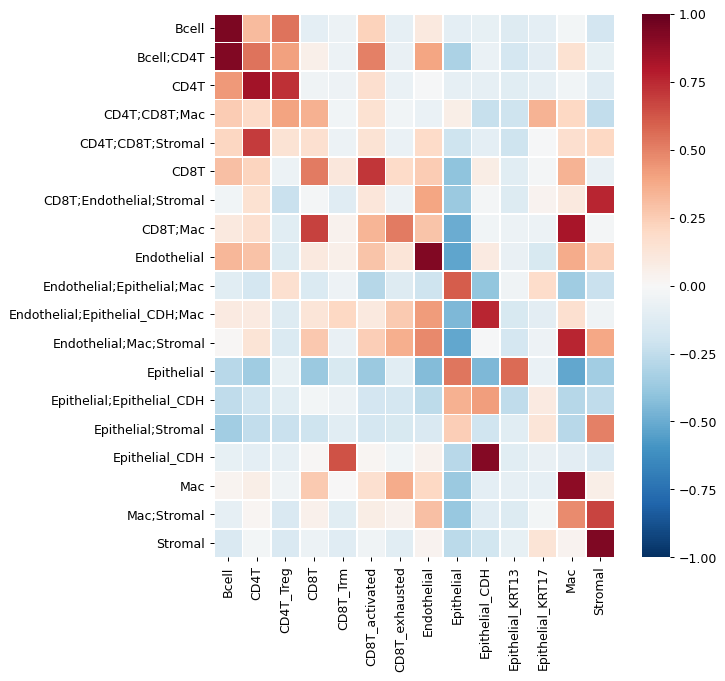

In [118]:
plt.figure(figsize=(8,8), dpi=90)
sns.heatmap(correlations, 
            cmap='RdBu_r', center=0, lw=0.5,
            vmax=1, vmin=-1,
            fmt='2.2f',
            square=True, ax=plt.gca())